In [5]:
from pkb_auth import get_pkb
import time
import snowflake.connector
from snowflake.connector import pandas_tools as sfpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from snowflake.connector.pandas_tools import write_pandas
from pathlib import Path
import pathlib
from xgboost import XGBRegressor,plot_importance, plot_tree
import seaborn as sns
import m2cgen as m2c
import os,datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
account_id, pkb = get_pkb()
ctx = snowflake.connector.connect(
    user='',
    account=account_id,
    private_key=pkb,
    warehouse="",
    database="",
    schema=""
    )
cur = ctx.cursor()

In [7]:
cur.execute("use role accountadmin;");
daily_table = 'top_stations_trips_daily'
ts_features_table = 'features_trips_station_data'
ts_lag_features_table = 'features_lags_trips_station_data'

##### Generate the required features from the base table

In [8]:
# We start from a table that has daily trips data for the top 5 stations.
# You can quickly do this from citibike data.
cur.execute(f"select * from {daily_table} limit 5")
trips_daily = cur.fetch_pandas_all()
trips_daily

,DS,START_STATION,TRIPS
0,2018-09-03,W 21 St & 6 Ave,286
1,2018-09-16,W 21 St & 6 Ave,329
2,2014-12-15,W 21 St & 6 Ave,206
3,2014-12-04,Broadway & E 22 St,163
4,2014-12-09,Broadway & E 22 St,38


In [9]:
gen_ts_features = f"""
with le_data as /* generates label enconding for the start station */
(select start_station, row_number()over(order by start_station)-1 as le_start_station from
(select distinct start_station from top_stations_trips_daily)
)
select a.*,
year(a.ds) as year, /* Year*/
month(a.ds) as month_num, /* Month */
dayofmonth(a.ds) as dom, /* Day of month*/
dayofweek(a.ds) as day_of_week_num, /* Day of the week */
weekofyear(a.ds) as week_num,  /* Week of the Year */
quarter(a.ds) as quarter_num, /* Quarter */
b.ds as last_year_date, /*Date Last Year*/
b.trips as ly_val, /* Trips Last Year */
dayofweek(b.ds) as last_year_dow, /* Day of the week Last Year*/
le_data.le_start_station from 
{daily_table} a 
left join 
{daily_table} b on DATEADD(YEAR, -1, a.ds) = b.ds and a.start_station=b.start_station
inner join le_data on a.start_station= le_data.start_station
order by start_station,ds;
"""

sql = f"create or replace view citibike.demo.{ts_features_table} as {gen_ts_features}"
cur.execute(sql);


cur.execute(f"select * from {ts_features_table} limit 5")
features_trips_station_data = cur.fetch_pandas_all()
features_trips_station_data

,DS,START_STATION,TRIPS,YEAR,MONTH_NUM,DOM,DAY_OF_WEEK_NUM,WEEK_NUM,QUARTER_NUM,LAST_YEAR_DATE,LY_VAL,LAST_YEAR_DOW,LE_START_STATION
0,2018-05-07,Broadway & E 22 St,504,2018,5,7,1,19,2,2017-05-07,215,0,0
1,2018-05-08,Broadway & E 22 St,522,2018,5,8,2,19,2,2017-05-08,462,1,0
2,2018-05-09,Broadway & E 22 St,554,2018,5,9,3,19,2,2017-05-09,488,2,0
3,2018-05-10,Broadway & E 22 St,490,2018,5,10,4,19,2,2017-05-10,539,3,0
4,2018-05-11,Broadway & E 22 St,477,2018,5,11,5,19,2,2017-05-11,549,4,0


In [10]:
gen_lag_features = f"""
select  *,
lag(trips,1)over (partition by start_station order by ds) as lag_1_val,
lag(trips,2)over (partition by start_station order by ds) as lag_2_val,
lag(trips,7)over (partition by start_station order by ds) as lag_7_val,
lead(trips,1) over (partition by start_station order by ds) as next_trips
from {ts_features_table};
"""
sql = f"create or replace view {ts_lag_features_table} as {gen_lag_features}"
cur.execute(sql);
cur.execute(f"select * from {ts_lag_features_table}")
features_trips_station_data = cur.fetch_pandas_all()
features_trips_station_data['LE_START_STATION'] =features_trips_station_data['LE_START_STATION'].astype('int')
features_trips_station_data.tail(10)

,DS,START_STATION,TRIPS,YEAR,MONTH_NUM,DOM,DAY_OF_WEEK_NUM,WEEK_NUM,QUARTER_NUM,LAST_YEAR_DATE,LY_VAL,LAST_YEAR_DOW,LE_START_STATION,LAG_1_VAL,LAG_2_VAL,LAG_7_VAL,NEXT_TRIPS
14329,2021-03-23,Broadway & E 22 St,212,2021,3,23,2,12,1,2020-03-23,19.0,1.0,0,219.0,218.0,160.0,148.0
14330,2021-03-24,Broadway & E 22 St,148,2021,3,24,3,12,1,2020-03-24,106.0,2.0,0,212.0,219.0,170.0,253.0
14331,2021-03-25,Broadway & E 22 St,253,2021,3,25,4,12,1,2020-03-25,55.0,3.0,0,148.0,212.0,88.0,263.0
14332,2021-03-26,Broadway & E 22 St,263,2021,3,26,5,12,1,2020-03-26,78.0,4.0,0,253.0,148.0,160.0,256.0
14333,2021-03-27,Broadway & E 22 St,256,2021,3,27,6,12,1,2020-03-27,87.0,5.0,0,263.0,253.0,223.0,139.0
14334,2021-03-28,Broadway & E 22 St,139,2021,3,28,0,12,1,2020-03-28,55.0,6.0,0,256.0,263.0,218.0,188.0
14335,2021-03-29,Broadway & E 22 St,188,2021,3,29,1,13,1,2020-03-29,40.0,0.0,0,139.0,256.0,219.0,237.0
14336,2021-03-30,Broadway & E 22 St,237,2021,3,30,2,13,1,2020-03-30,63.0,1.0,0,188.0,139.0,212.0,199.0
14337,2021-03-31,Broadway & E 22 St,199,2021,3,31,3,13,1,2020-03-31,67.0,2.0,0,237.0,188.0,148.0,18.0
14338,2021-04-01,Broadway & E 22 St,18,2021,4,1,4,13,2,2020-04-01,76.0,3.0,0,199.0,237.0,253.0,NaN


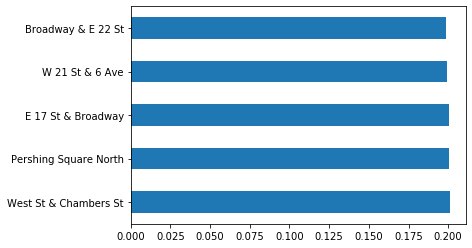

In [11]:
features_trips_station_data['START_STATION'].value_counts(normalize=True).plot(kind='barh');

In [12]:
print(f"INFO: Min = {features_trips_station_data[features_trips_station_data['START_STATION']=='E 17 St & Broadway'].DS.min()}, Max= {features_trips_station_data.DS.max()}")
# Simple Range check
stn = features_trips_station_data['START_STATION']
(
(features_trips_station_data[stn=='E 17 St & Broadway'].DS.min(), features_trips_station_data[stn=='E 17 St & Broadway'].DS.max()) ,
(features_trips_station_data[stn=='Pershing Square North'].DS.min(), features_trips_station_data[stn=='Pershing Square North'].DS.max()) ,
(features_trips_station_data[stn=='W 21 St & 6 Ave'].DS.min(), features_trips_station_data[stn=='W 21 St & 6 Ave'].DS.max()) ,
(features_trips_station_data[stn=='Broadway & E 22 St'].DS.min(), features_trips_station_data[stn=='Broadway & E 22 St'].DS.max()) ,
(features_trips_station_data[stn=='West St & Chambers St'].DS.min(), features_trips_station_data[stn=='West St & Chambers St'].DS.max())
)

INFO: Min = 2013-06-01, Max= 2021-04-30


((datetime.date(2013, 6, 1), datetime.date(2021, 4, 30)),
 (datetime.date(2013, 6, 1), datetime.date(2021, 4, 30)),
 (datetime.date(2013, 6, 1), datetime.date(2021, 4, 30)),
 (datetime.date(2013, 6, 1), datetime.date(2021, 4, 1)),
 (datetime.date(2013, 6, 1), datetime.date(2021, 4, 30)))

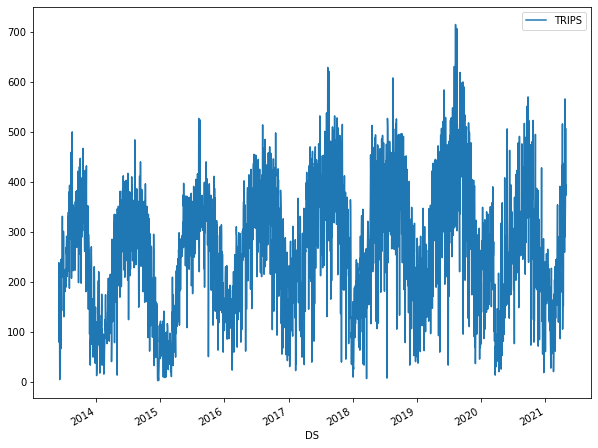

In [13]:
features_trips_station_data['DS'] = pd.to_datetime(features_trips_station_data['DS'])
features_trips_station_data[stn=='E 17 St & Broadway'][['DS','TRIPS']].plot(x='DS',figsize = (10,8));
# features_trips_station_data[stn=='Pershing Square North'][['DS','TRIPS']].plot(x='DS');

#### Split data and prep for model building

In [14]:
train_flag =features_trips_station_data['DS']<'2021-01-01'
train_df = features_trips_station_data[train_flag].drop(['START_STATION','LAST_YEAR_DATE'], axis =1)
test_flag = features_trips_station_data['DS']>'2021-01-01'
test_df = features_trips_station_data[test_flag].drop(['START_STATION','LAST_YEAR_DATE'], axis =1)

In [15]:
x_cols = [i for i in train_df.columns if i.lower() not in 'next_trips']
x_cols.remove('DS')
X_train,y_train = train_df[x_cols], train_df['TRIPS']
X_test,y_test = test_df[x_cols], test_df['TRIPS']

In [16]:
reg = XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=6, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

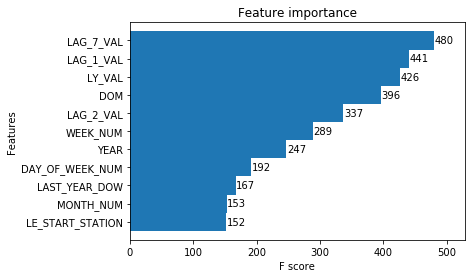

In [17]:
plot_importance(reg, height=1.0, grid=False); # get feature importance plot

In [18]:
test_df['next_pred'] = reg.predict(X_test)

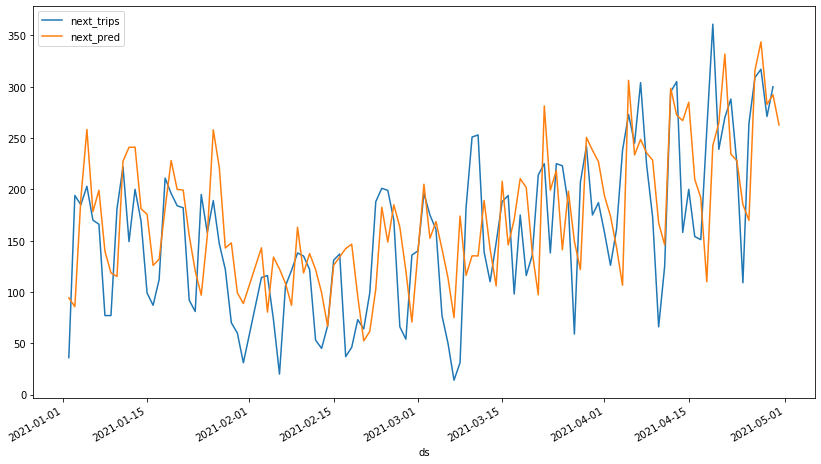

In [19]:
#For Pershing Sq North - Check out the predictions 
test_df.columns = [i.lower() for i in test_df.columns]
test_df[test_df['le_start_station']==2][['ds','next_trips','next_pred']].sort_values(by='ds').set_index('ds').tail(120).plot(figsize=(14,8));

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
testd_df = test_df.dropna()
print("---- Model Metrics ---")
print(f"INFO: MAPE : {round(mean_absolute_percentage_error(testd_df['next_trips'],testd_df['next_pred']),2)}")
print(f"INFO: MSE: {round(mean_squared_error(y_true=testd_df['next_trips'],y_pred=testd_df['next_pred']),2)}")

---- Model Metrics ---
INFO: MAPE : 46.31
INFO: MSE: 4722.86


### Convert the model to Java so we can deploy it as Java UDF back into Snowflake

In [22]:
def make_java_file(filehandle:str, code:str) -> str:
    """Simple Java File Maker

    Args:
        filehandle (str): Name of your Java File.
        code (str): Java Code to write into the generated file.

    Returns:
        str: Only returns 'done', doesn't handle exceptions.
    """    
    txt_filename = f"{filehandle}.txt"
    java_filename = f"{filehandle}.java"
    os.system(f'touch {txt_filename}')
    with open(txt_filename,'w') as f:
        f.write(code)
    os.system(f'mv {txt_filename} {java_filename}')
    return 'done'

In [24]:
code = m2c.export_to_java(reg)
make_java_file('xgb_to_java',code) 

'done'

In [25]:
cur.execute('create or replace stage my_models;'); # create a stage to host the model

In [26]:
make_java_udf_sql = f"""
create or replace function score_xgbmodel(a ARRAY)
returns double
language java
handler='Model.score'
target_path='@my_models/xgb_model.jar'
as
$$
{code}
$$
"""
cur.execute(make_java_udf_sql);

Check to see if the JAR file exists in the stage

In [27]:
cur.execute("""select distinct metadata$filename as files from @my_models;""")
cur.fetch_pandas_all()

,FILES
0,xgb_model.jar


❄️ ❄️ ❄️ ❄️ Score with (new) data! ❄️ ❄️ ❄️ ❄️ 

In [28]:

score_udf_sql = f"""
select a.*,
score_xgbmodel(
array_construct( 
YEAR,MONTH_NUM,
DOM,
DAY_OF_WEEK_NUM,
WEEK_NUM,
QUARTER_NUM,
LY_VAL,
LAST_YEAR_DOW,
LE_START_STATION,
LAG_1_VAL,
LAG_2_VAL,
LAG_7_VAL)
) as model_prediction
from
(select * from {ts_lag_features_table} where year='2021' and next_trips is null) a;
"""
cur.execute(score_udf_sql);
results_df = cur.fetch_pandas_all()
results_df.tail(10)

,DS,START_STATION,TRIPS,YEAR,MONTH_NUM,DOM,DAY_OF_WEEK_NUM,WEEK_NUM,QUARTER_NUM,LAST_YEAR_DATE,LY_VAL,LAST_YEAR_DOW,LE_START_STATION,LAG_1_VAL,LAG_2_VAL,LAG_7_VAL,NEXT_TRIPS,MODEL_PREDICTION
0,2021-04-30,W 21 St & 6 Ave,369,2021,4,30,5,17,2,2020-04-30,69,4,3,317,395,336,NaN,330.899190
1,2021-04-30,E 17 St & Broadway,394,2021,4,30,5,17,2,2020-04-30,52,4,1,373,507,402,NaN,326.148586
2,2021-04-30,West St & Chambers St,262,2021,4,30,5,17,2,2020-04-30,74,4,4,249,441,286,NaN,239.209860
3,2021-04-30,Pershing Square North,300,2021,4,30,5,17,2,2020-04-30,34,4,2,271,317,288,NaN,262.658637
4,2021-04-01,Broadway & E 22 St,18,2021,4,1,4,13,2,2020-04-01,76,3,0,199,237,253,NaN,204.004519


Now let's see how we can go perform multi-step forecasts for a forward looking horizon

In [29]:
start_station ='Pershing Square North' # Select Some Station
horizon = 7 # Forecasting Horizon
tbl='RESULTS_TBL'
dates_tbl = 'PREDICTION_DATES'
start_timestamp = features_trips_station_data[stn==start_station].DS.max()
end_timestamp = start_timestamp + datetime.timedelta(days=horizon)  # move 8 ahead
range_df = pd.DataFrame(pd.date_range(start_timestamp,end_timestamp),columns=['DS'])
max_day_df = features_trips_station_data[features_trips_station_data['DS'] == start_timestamp]
max_day_df = max_day_df[max_day_df['START_STATION']==start_station]
max_day_df=max_day_df.append(range_df.iloc[1:,]).reset_index().drop(['index'],axis=1)
max_day_df['START_STATION']=start_station
max_day_df['DS']=max_day_df['DS'].dt.date
sql = f"create or replace table {tbl} like {ts_lag_features_table};"
dates =f"create or replace table {dates_tbl} like {tbl}";
cur.execute(f'drop table if exists {tbl}')
cur.execute(sql);
cur.execute(dates);
success, nchunks, nrows, _ = sfpd.write_pandas(ctx, max_day_df,dates_tbl)
cur.execute('alter table results_tbl add column next_prediction numeric;')
print("INFO: Predictions Table Created")

INFO: Predictions Table Created


In [30]:
from score_in_snowflake import score_new_data  # Abstracted SQL queries

In [31]:
for i,p_date in enumerate(max_day_df['DS']):
    print(f"INFO: Now Scoring: {p_date}")
    if (i == 0):
        cur.execute(score_new_data(p_date,
                                   ts_lag_features_table,
                                   dates_tbl,
                                   results_tbl=tbl)[0])
    else:
        cur.execute(score_new_data(p_date,
                                   ts_lag_features_table,
                                   dates_tbl,
                                   results_tbl=tbl)[1])

INFO: Now Scoring: 2021-04-30
INFO: Now Scoring: 2021-05-01
INFO: Now Scoring: 2021-05-02
INFO: Now Scoring: 2021-05-03
INFO: Now Scoring: 2021-05-04
INFO: Now Scoring: 2021-05-05
INFO: Now Scoring: 2021-05-06
INFO: Now Scoring: 2021-05-07


#### Check out the results

In [32]:
cur.execute(f'select * from {tbl}')
results_df = cur.fetch_pandas_all()
results_df.sort_values(by='DS').set_index('DS')

,START_STATION,TRIPS,YEAR,MONTH_NUM,DOM,DAY_OF_WEEK_NUM,WEEK_NUM,QUARTER_NUM,LAST_YEAR_DATE,LY_VAL,LAST_YEAR_DOW,LE_START_STATION,LAG_1_VAL,LAG_2_VAL,LAG_7_VAL,NEXT_TRIPS,NEXT_PREDICTION
DS,,,,,,,,,,,,,,,,,
2021-04-30,Pershing Square North,300,2021,4,30,5,17,2,2020-04-30,34,4,2,271,317,288,NaN,263
2021-05-01,Pershing Square North,263,2021,5,1,6,17,2,2020-05-01,59,5,2,300,271,288,NaN,263
2021-05-02,Pershing Square North,263,2021,5,2,0,17,2,2020-05-02,77,6,2,263,300,225,NaN,175
2021-05-03,Pershing Square North,175,2021,5,3,1,18,2,2020-05-03,76,0,2,263,263,109,NaN,410
2021-05-04,Pershing Square North,410,2021,5,4,2,18,2,2020-05-04,79,1,2,175,263,264,NaN,269
2021-05-05,Pershing Square North,269,2021,5,5,3,18,2,2020-05-05,98,2,2,410,175,309,NaN,368
2021-05-06,Pershing Square North,368,2021,5,6,4,18,2,2020-05-06,52,3,2,269,410,317,NaN,293
2021-05-07,Pershing Square North,293,2021,5,7,5,18,2,2020-05-07,96,4,2,368,269,271,NaN,330


In [30]:
cur.close()

True